In [ ]:
# Packages imports
import numpy as np
import pandas as pd
import scipy.stats as stats
import statsmodels.stats.api as sms
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from math import ceil

%matplotlib inline

# Some plot styling preferences
plt.style.use('seaborn-whitegrid')
font = {'family' : 'Helvetica',
        'weight' : 'bold',
        'size'   : 14}

mpl.rc('font', **font)

In [ ]:
df = pd.read_excel("data.xlsx")

In [ ]:
df.head()

,user_id,test,converted,tot_impr,mode_impr_day,mode_impr_hour
0,1069124,1,0,130,1,20
1,1119715,1,0,93,2,22
2,1144181,1,0,21,2,18
3,1435133,1,0,355,2,10
4,1015700,1,0,276,5,14


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 588101 entries, 0 to 588100
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype
---  ------          --------------   -----
 0   user_id         588101 non-null  int64
 1   test            588101 non-null  int64
 2   converted       588101 non-null  int64
 3   tot_impr        588101 non-null  int64
 4   mode_impr_day   588101 non-null  int64
 5   mode_impr_hour  588101 non-null  int64
dtypes: int64(6)
memory usage: 26.9 MB


In [ ]:
pd.crosstab(df['test'], df['converted'])

converted,0,1
test,,
0,23104,420
1,550154,14423


In [ ]:
session_counts = df['user_id'].value_counts(ascending=False)
multi_users = session_counts[session_counts > 1].count()

print(f'There are {multi_users} users that appear multiple times in the dataset')

There are 0 users that appear multiple times in the dataset


In [ ]:

effect_size = sms.proportion_effectsize(0.02, 0.04)    # Calculating effect size based on our expected rates

required_n = sms.NormalIndPower().solve_power(
    effect_size, 
    power=0.8, 
    alpha=0.05, 
    ratio=1
    )                                                  # Calculating sample size needed

required_n = ceil(required_n)                          # Rounding up to next whole number                          

print(required_n)

1110


In [ ]:
required_n = 10000

In [ ]:
control_sample = df[df['test'] == 0].sample(n=required_n, random_state=22)
treatment_sample = df[df['test'] == 1].sample(n=required_n, random_state=22)

ab_test = pd.concat([control_sample, treatment_sample], axis=0)
ab_test.reset_index(drop=True, inplace=True)

In [ ]:
ab_test


,user_id,test,converted,tot_impr,mode_impr_day,mode_impr_hour
0,916702,0,0,7,1,17
1,911687,0,0,2,6,23
2,911494,0,0,6,5,21
3,922101,0,0,15,5,10
4,904432,0,0,23,7,10
...,...,...,...,...,...,...
19995,1232630,1,0,1,5,12
19996,1103356,1,0,4,5,18
19997,1283337,1,0,8,4,20
19998,1267058,1,0,30,4,17


In [ ]:
ab_test.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   user_id         20000 non-null  int64
 1   test            20000 non-null  int64
 2   converted       20000 non-null  int64
 3   tot_impr        20000 non-null  int64
 4   mode_impr_day   20000 non-null  int64
 5   mode_impr_hour  20000 non-null  int64
dtypes: int64(6)
memory usage: 937.6 KB


In [ ]:
ab_test['test'].value_counts()

1    10000
0    10000
Name: test, dtype: int64

In [41]:
conversion_rates = ab_test.groupby('test')['converted']

std_p = lambda x: np.std(x, ddof=0)              # Std. deviation of the proportion
se_p = lambda x: stats.sem(x, ddof=0)            # Std. error of the proportion (std / sqrt(n))

conversion_rates = conversion_rates.agg([np.mean, std_p, se_p])
conversion_rates.columns = ['conversion_rate', 'std_deviation', 'std_error']
a = conversion_rates.style.format('{:.3f}')
print(conversion_rates)
#conversion_rates.style.format('{:.3f}')

      conversion_rate  std_deviation  std_error
test                                           
0              0.0175       0.131125   0.001311
1              0.0249       0.155820   0.001558


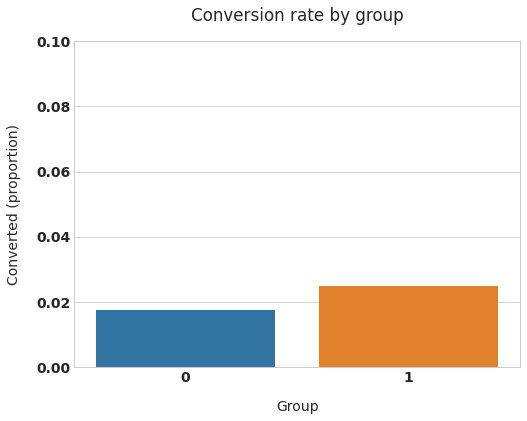

In [ ]:
plt.figure(figsize=(8,6))

sns.barplot(x=ab_test['test'], y=ab_test['converted'], ci=False)

plt.ylim(0, 0.10)
plt.title('Conversion rate by group', pad=20)
plt.xlabel('Group', labelpad=15)
plt.ylabel('Converted (proportion)', labelpad=15);

In [ ]:
from statsmodels.stats.proportion import proportions_ztest, proportion_confint

In [ ]:
control_results = ab_test[ab_test['test'] == 0]['converted']
treatment_results = ab_test[ab_test['test'] == 1]['converted']

In [ ]:
n_con = control_results.count()
n_treat = treatment_results.count()
successes = [control_results.sum(), treatment_results.sum()]
nobs = [n_con, n_treat]

z_stat, pval = proportions_ztest(successes, nobs=nobs)
(lower_con, lower_treat), (upper_con, upper_treat) = proportion_confint(successes, nobs=nobs, alpha=0.05)

print(f'z statistic: {z_stat:.2f}')
print(f'p-value: {pval:.3f}')
print(f'ci 95% for PSA group: [{lower_con:.3f}, {upper_con:.3f}]')
print(f'ci 95% for Real Ad group: [{lower_treat:.3f}, {upper_treat:.3f}]')

z statistic: -3.63
p-value: 0.000
ci 95% for PSA group: [0.015, 0.020]
ci 95% for Real Ad group: [0.022, 0.028]
